In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [13]:
# Load STRIPS data
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
times = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
yields = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100  # Convert to percentage
valid_idx = ~np.isnan(times) & ~np.isnan(yields)
times = times[valid_idx]
yields = yields[valid_idx]

In [14]:
# Two-Factor Hull-White Model
class Two_Factor_Hull_White:
    def __init__(self, kappa1, kappa2, vol1, vol2, times, yields):
        self.kappa1 = kappa1
        self.kappa2 = kappa2
        self.vol1 = vol1
        self.vol2 = vol2
        self.var1 = vol1**2
        self.var2 = vol2**2
        self.times = times
        self.yields = yields / 100  # Convert to decimal
        self.r0 = self.yields[0]  # Use the shortest maturity yield as r(0)
        self._fit_phi()

    def B(self, tau, kappa):
        if tau <= 0:
            return 0
        return (1 - np.exp(-kappa * tau)) / kappa

    def A(self, t, T, kappa, var):
        tau = T - t
        if tau <= 0:
            return 0
        B_tau = self.B(tau, kappa)
        return (var / (2 * kappa**2)) * (tau - B_tau - (B_tau**2) / (2 * kappa))

    def _fit_phi(self):
        # Fit the deterministic function phi(t) to match the initial yield curve
        # Compute zero-coupon bond prices from observed yields
        zero_prices = np.exp(-self.yields * self.times)
        self.zero_price_interp = interp1d(self.times, zero_prices, fill_value="extrapolate", kind='linear')

        # Compute the forward rate f(0, T) = -d/dT ln(P(0, T))
        forward_rates = -np.diff(np.log(zero_prices)) / np.diff(self.times)
        forward_times = (self.times[:-1] + self.times[1:]) / 2
        self.forward_rate_interp = interp1d(forward_times, forward_rates, fill_value="extrapolate", kind='linear')

        # Compute phi(t) using the forward rate: phi(t) = f(0, t) + sum_i (sigma_i^2 / (2 kappa_i^2)) (1 - e^(-kappa_i t))^2
        def phi(t):
            if t <= 0:
                return self.r0
            f0t = self.forward_rate_interp(t)
            term1 = (self.var1 / (2 * self.kappa1**2)) * (1 - np.exp(-self.kappa1 * t))**2
            term2 = (self.var2 / (2 * self.kappa2**2)) * (1 - np.exp(-self.kappa2 * t))**2
            return f0t + term1 + term2

        # Interpolate phi(t)
        phi_times = np.linspace(0, max(self.times), 100)
        phi_values = np.array([phi(t) for t in phi_times])
        self.phi_interp = interp1d(phi_times, phi_values, fill_value="extrapolate", kind='linear')

    def phi(self, t):
        return self.phi_interp(t)

    def yield_curve(self, t, T, r_t):
        tau = T - t
        if tau <= 0:
            return np.nan
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        A1 = self.A(t, T, self.kappa1, self.var1)
        A2 = self.A(t, T, self.kappa2, self.var2)
        # Integrate phi(s) * (B1(T-s) + B2(T-s)) from t to T
        integrand = lambda s: self.phi(s) * (self.B(T - s, self.kappa1) + self.B(T - s, self.kappa2))
        integral, _ = quad(integrand, t, T)
        price = np.exp(A1 + A2 - (B1 + B2) * r_t + integral)
        price = max(price, 1e-10)
        return -np.log(price) / tau

    def simulate_paths(self, T, dt, n_paths):
        n_steps = int(T / dt)
        times = np.linspace(0, T, n_steps + 1)
        r_paths = np.zeros((n_paths, n_steps + 1))
        x1 = np.zeros((n_paths, n_steps + 1))
        x2 = np.zeros((n_paths, n_steps + 1))
        x1[:, 0] = 0  # x1(0) = 0
        x2[:, 0] = 0  # x2(0) = 0
        r_paths[:, 0] = self.r0  # r(0) = observed short rate

        for t in range(1, n_steps + 1):
            dW1 = np.random.normal(0, np.sqrt(dt), n_paths)
            dW2 = np.random.normal(0, np.sqrt(dt), n_paths)
            x1[:, t] = x1[:, t-1] - self.kappa1 * x1[:, t-1] * dt + self.vol1 * dW1
            x2[:, t] = x2[:, t-1] - self.kappa2 * x2[:, t-1] * dt + self.vol2 * dW2
            r_paths[:, t] = np.maximum(x1[:, t] + x2[:, t] + self.phi(times[t]), 0)

        return times, r_paths

In [15]:
# Fit the Hull-White model
kappa1, kappa2 = 0.1, 0.1  # Mean-reversion rates
vol1, vol2 = 0.005, 0.005  # Reduced volatilities for more realistic forecasts
model = Two_Factor_Hull_White(kappa1, kappa2, vol1, vol2, times, yields)

# Verify the fit at t=0
fitted_yields = np.array([model.yield_curve(0, t, model.r0) * 100 for t in times])
print("Fitted yields at t=0:", fitted_yields)
print("Observed yields:", yields)

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_76345/3644805323.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, T)


Fitted yields at t=0: [  5.78381907   2.60091198  -0.49296173  -3.72229425  -6.85238066
  -9.95793697 -13.03133776 -16.03832817 -18.93131406 -21.73637259
 -34.24717342   7.30232625   4.16570067   1.06767364  -2.12965157
  -5.29760649 -11.51318708 -14.55763519 -17.50746245 -20.35789277
 -25.64689084 -28.12310832 -30.57598245 -33.00772009   6.57149674
   3.37949649   0.31057892  -2.91997677  -6.06163612  -9.17731029
 -12.26118958 -15.29404842 -18.20952279 -21.03890165 -28.72124569
 -31.17157603 -33.60998919   4.98098125   1.83769886  -1.31273663
  -4.51158176 -10.7366589  -13.79770794 -16.77544628 -19.64761673
 -22.42444376]
Observed yields: [3.694 4.088 4.169 4.157 4.289 4.354 4.403 4.431 4.464 4.495 4.658 2.52
 4.081 3.973 4.252 4.173 4.357 4.419 4.448 4.483 4.371 4.451 4.548 4.597
 4.204 4.221 4.222 4.262 4.299 4.317 4.387 4.419 4.458 4.487 4.486 4.544
 4.645 4.243 3.887 4.182 4.277 4.345 4.417 4.409 4.464 4.499]


In [16]:
# Forecasting
T = 1.0  # 1-year horizon
dt = 1/252  # Daily steps
n_paths = 1000  # Number of simulations
times_sim, r_paths = model.simulate_paths(T, dt, n_paths)

# Compute yield curves at forecast end (t = 1 year)
forecast_maturities = np.linspace(0.1, 10, 20)
yield_forecasts = np.zeros((n_paths, len(forecast_maturities)))

for i in range(n_paths):
    r_t = r_paths[i, -1]  # Short rate at T=1
    yield_forecasts[i, :] = [model.yield_curve(T, T + tau, r_t) * 100 for tau in forecast_maturities]

# Aggregate results
mean_yields = np.mean(yield_forecasts, axis=0)
lower_yields = np.percentile(yield_forecasts, 5, axis=0)
upper_yields = np.percentile(yield_forecasts, 95, axis=0)

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_76345/3644805323.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, T)


In [17]:
mean_yields

array([  8.26227556,   6.66600747,   5.02574827,   3.24555809,
         1.4382089 ,  -0.31509997,  -2.03782825,  -3.76890476,
        -5.48257999,  -7.19280344,  -8.89174263, -10.57525265,
       -12.22842539, -13.8447861 , -15.43557092, -17.0027612 ,
       -18.54150415, -20.03888888, -21.47126497, -22.8528132 ])

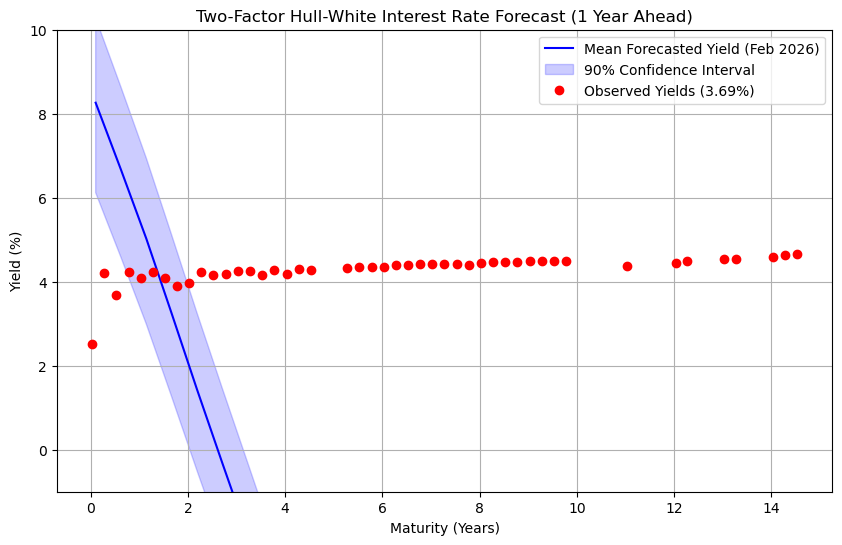

In [18]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(forecast_maturities, mean_yields, label='Mean Forecasted Yield (Feb 2026)', color='blue')
plt.fill_between(forecast_maturities, lower_yields, upper_yields, color='blue', alpha=0.2, label='90% Confidence Interval')
plt.plot(times, yields, 'o', label=f'Observed Yields ({yields[0]:.2f}%)', color='red')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('Two-Factor Hull-White Interest Rate Forecast (1 Year Ahead)')
plt.legend()
plt.grid(True)
plt.ylim(-1, 10)
plt.show()

# Save forecast results
forecast_df = pd.DataFrame({
    'Maturity': forecast_maturities,
    'Mean_Yield': mean_yields,
    'Lower_5th': lower_yields,
    'Upper_95th': upper_yields
})
forecast_df.to_csv('hull_white_two_factor_forecast.csv', index=False)